In [1]:
import pandas as pd
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os
#from pytorch_lightning import LightningModule, Trainer
import matplotlib.pyplot as plt
import time 
from sklearn.metrics import roc_curve, auc
import torch.optim as optim
from torchmetrics.classification import MulticlassCohenKappa
from sklearn.metrics import cohen_kappa_score, roc_auc_score
from torch.nn.utils.rnn import pad_sequence
from sleep_datasets import SleepDataset, SleepChunkDataset
from sklearn.utils.class_weight import compute_class_weight

### Construct Dataset Class

### Split Subjects into Train/Val/Test

In [6]:
participant_info_df = pd.read_csv('/scratch/npr264/BioDeepL/dreamt/physionet.org/files/dreamt/2.0.0/participant_info.csv')
subjects_all = participant_info_df['SID']

subjects_all_shuffled = participant_info_df['SID'].sample(frac=1, random_state=42).reset_index(drop=True)
subjects_train = subjects_all_shuffled[:int(len(subjects_all_shuffled)*0.7)]
subjects_val = subjects_all_shuffled[int(len(subjects_all_shuffled)*0.7):int(len(subjects_all_shuffled)*0.9)]
subjects_test = subjects_all_shuffled[int(len(subjects_all_shuffled)*0.9):]
print(f"number of subjects in train: {len(subjects_train)}")
print(f"number of subjects in val: {len(subjects_val)}")
print(f"number of subjects in test: {len(subjects_test)}")

# overwrite with smaller dataset for development (20% of original)
fraction = 0.3
subjects_train_small = subjects_train[:int(len(subjects_train)*fraction)]
subjects_val_small = subjects_val[:int(len(subjects_val)*fraction)]
subjects_test_small = subjects_test[:int(len(subjects_test)*fraction)]
print(f"number of subjects in small train: {len(subjects_train_small)}")
print(f"number of subjects in small val: {len(subjects_val_small)}")
print(f"number of subjects in small test: {len(subjects_test_small)}")

number of subjects in train: 70
number of subjects in val: 20
number of subjects in test: 10
number of subjects in small train: 21
number of subjects in small val: 6
number of subjects in small test: 3


### Initialize DataLoaders (big, full sequence @ 0.2 Hz)

In [7]:
target_freq = 0.2
datadir_64Hz = "/scratch/npr264/BioDeepL/dreamt/physionet.org/files/dreamt/2.0.0/data_64Hz"
max_length = 4096
train_dataset = SleepDataset(subjects_list=subjects_train,
                                 data_dir=datadir_64Hz,
                                 max_length=max_length,
                                 downsample_freq=target_freq, # downsample to 8Hz
                                 debug=False)
print(f"Total samples in train dataset: {len(train_dataset)}")
val_dataset = SleepDataset(subjects_list=subjects_val,
                                 data_dir=datadir_64Hz,
                                 max_length=max_length,
                                 downsample_freq=target_freq, # downsample to 8Hz
                                 debug=False)
print(f"Total samples in val dataset: {len(val_dataset)}")                                 
test_dataset = SleepDataset(subjects_list=subjects_test,
                                 data_dir=datadir_64Hz,
                                 max_length=max_length,
                                 downsample_freq=target_freq, # downsample to 8Hz
                                 debug=False)
print(f"Total samples in test dataset: {len(test_dataset)}")

Total samples in train dataset: 70
Total samples in val dataset: 20
Total samples in test dataset: 10


### Class Representation in train/test/val sets

In [9]:
train_labels = np.concatenate([train_dataset.__getitem__(i)[1].numpy().ravel() for i in range(train_dataset.__len__())])
val_labels = np.concatenate([val_dataset.__getitem__(i)[1].numpy().ravel() for i in range(val_dataset.__len__())])
test_labels = np.concatenate([test_dataset.__getitem__(i)[1].numpy().ravel() for i in range(test_dataset.__len__())])
class_weights = compute_class_weight(class_weight="balanced", classes=np.arange(4), y=train_labels[train_labels!=-1])

print(f"Sleep stage representation in train set:\n{pd.Series(train_labels).value_counts(normalize=True)}")
print(f"Sleep stage representation in val set:\n{pd.Series(val_labels).value_counts(normalize=True)}")
print(f"Sleep stage representation in test set:\n{pd.Series(test_labels).value_counts(normalize=True)}")

Sleep stage representation in train set:
 1    0.613560
 0    0.252595
 3    0.095030
 2    0.037556
-1    0.001259
Name: proportion, dtype: float64
Sleep stage representation in val set:
1    0.625305
0    0.228918
3    0.088538
2    0.057239
Name: proportion, dtype: float64
Sleep stage representation in test set:
 1    0.538013
 0    0.394531
 3    0.061841
 2    0.005322
-1    0.000293
Name: proportion, dtype: float64


### Construct SleepPPG-Net Blocks

In [11]:
#res conv module to be used in the ResConv stack
class ResConv(nn.Module):
    def __init__(self, num_layers, in_channels, out_channels, leak, kernel_size=3, pool_size=2, padding = 1):
        super(ResConv, self).__init__()
        conv_layers = nn.ModuleList([nn.Conv1d(in_channels, out_channels, kernel_size, padding=(kernel_size - 1) // 2, dtype=torch.float32)]+[nn.Conv1d(out_channels, out_channels, kernel_size, padding=(kernel_size - 1) // 2, dtype=torch.float32) for i in range(num_layers-1)])
        self.conv = nn.Sequential(*conv_layers)
        
        self.pool = nn.MaxPool1d(kernel_size=pool_size)
        self.norm = nn.BatchNorm1d(out_channels)
        # Project input if in_channels ≠ out_channels
        self.needs_shortcut = in_channels != out_channels
        self.shortcut = nn.Conv1d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else nn.Identity()
        self.activation = nn.LeakyReLU(leak)
        self._initialize_weights()
        self.dropout = nn.Dropout(0.05)
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)              
    def forward(self, x):
        if self.needs_shortcut:
            residual = self.shortcut(x)
        else:
            residual = x
        out = self.conv(x)
        out = self.pool(out)
        residual = self.pool(residual)

        out += residual
        out = self.dropout(out)
        return self.activation(out)
        
#temporal windowing block
class TemporalWindow(nn.Module):
    def __init__(self, window_size):
        super().__init__()
        self.window_size = window_size

    def forward(self, x):
        batch_size, C, L = x.shape
        x = x.reshape(batch_size, -1, self.window_size)
        return x

#time distributed dnn block
class TimeDistributed(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout, leak):
        super(TimeDistributed, self).__init__()
        self.module = nn.Sequential(
            nn.Linear(in_channels, out_channels),
            nn.LeakyReLU(leak),
            nn.Dropout(dropout)
        )
        self._initialize_weights()
        
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # x: [batch_size, time_steps, input_dim]
        batch_size, input_dim, time_steps = x.size()
        x_reshaped = x.contiguous().view(-1, input_dim) # Flatten batch and time: [batch_size * time_steps, input_dim]
        y = self.module(x_reshaped)         # Apply module
        output_dim = y.size(-1)         # Reshape back to [batch_size, time_steps, output_dim]
        y = y.view(batch_size, output_dim, time_steps)
        return y

#TCN block
class TCNBlock(nn.Module):
    def __init__(self, tcn_depth, in_channels, out_channels, leak, kernel_size=7, dropout=0.1):
        super(TCNBlock, self).__init__()

        self.dropout = nn.Dropout(dropout)
        dilation_rates = [1,2,4,8,16,32]
        conv_layers = nn.ModuleList([nn.Conv1d(in_channels, in_channels, kernel_size, padding=(kernel_size - 1) * dilation_rates[i] // 2, dilation = dilation_rates[i]) for i in range(tcn_depth)])
        self.conv = nn.Sequential(*conv_layers)
        self.residual = nn.Conv1d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else nn.Identity()
        self.activation = nn.LeakyReLU(leak)
        self._initialize_weights()
        
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        residual = self.residual(x)
        out = self.conv(x)
        out = out + residual
        out = self.dropout(out)
        return self.activation(out)

#prediction block
class PredictConv(nn.Module):
    def __init__(self, in_channels, num_classes, kernel_size=1):
        super(PredictConv, self).__init__()
        self.conv = nn.Conv1d(in_channels, num_classes, kernel_size)
       
    def forward(self, x):
        out = self.conv(x) 
        return out

### Construct Sleep Staging Model

In [12]:

class SleepStager(nn.Module):
    def __init__(self, flist_resconv, resconv_depth, resconv_kernel_size, h_dnn, o_dnn, num_layers_tcn, tcn_depth, tcn_kernel_size, output_dim, seq_length, window_size, dropout, leak):
        super(SleepStager, self).__init__()
    
        self.flist_resconv = flist_resconv #must start with 1, then specify output filter size for all intended resconv layers in the block (i.e for 8 filters this list should be 9 elements long)
        self.n_resconv_layers = len(flist_resconv) - 1
        self.in_dnn = int(((seq_length/(2**self.n_resconv_layers))/window_size)*flist_resconv[-1])
        
        #resconv block
        self.resconv = nn.ModuleList([ResConv(resconv_depth, flist_resconv[i-1], flist_resconv[i], leak, kernel_size=resconv_kernel_size, pool_size=2) for i in range(1,len(flist_resconv))])
        
        #temporal window block
        self.temp_window = TemporalWindow(window_size=window_size)

        #time distributed dnn block 
        self.dnn = TimeDistributed(self.in_dnn, h_dnn, o_dnn, dropout, leak) #1024 = dimension size from temporal window (fixed), 512 = hidden dimension size (learnable), 128 = output dim size (fixed)

        #TCN block
        self.tcn = nn.ModuleList([TCNBlock(tcn_depth, o_dnn, o_dnn, leak, kernel_size=tcn_kernel_size, dropout = dropout) for i in range(num_layers_tcn)])

        #final conv layer for prediction 
        self.predconv = PredictConv(o_dnn, output_dim, kernel_size=1)
        self.activation = nn.LeakyReLU(leak)
        
    def forward(self, x): #x shape: [batch_size, 1, 1228800]
        out = x
        for resconv in self.resconv: # shape: [batch_size, Frc8, 4800]
            out = resconv(out)
        #print(f"res conv: {out.shape}")
        out = self.temp_window(out) #shape: [batch_size, self.in_dnn, 1200]
        #print(f"temp window: {out.shape}")
        out = self.dnn(out) #shape: [batch_size, 128, 1200]
        #print(f"dnn: {out.shape}")
        for tcn in self.tcn: #shape: [batch_size, 128, 1200]
            out = tcn(out)
        out = self.predconv(out) #shape: [batch_size, 4, 1200]
        return out

### Define model training loop

In [13]:
def row_mode(row):
    vals, counts = np.unique(row, return_counts=True)
    return vals[np.argmax(counts)]

def resize_labels_predictions(outputs, labels, device):
    batch_size, num_classes, num_windows = outputs.shape
    window_size = labels.shape[1]//num_windows
    idx = torch.linspace(0, labels.shape[1] - 1, num_windows).long()
    y_resampled = labels[:, idx].squeeze(1).long()
    y_hat = outputs.reshape(batch_size * num_windows, num_classes)
    y_true = y_resampled.reshape(batch_size * num_windows,).long().to(device)
    return y_hat, y_true
    
def train(model, iterator, optimizer, criterion, device):
    epoch_loss = []
    epoch_acc = 0
    model.train()
    batch_counter = 0
    start_time = time.time()
#    torch.cuda.reset_peak_memory_stats(device)
    for sequences, labels in iterator:
        labels = labels.to(device)
        sequences = sequences.to(device)
        optimizer.zero_grad()
        outputs = model(sequences)

        y_hat, y_true = resize_labels_predictions(outputs, labels, device)
        
        loss = criterion(y_hat, y_true)
        acc = calculate_accuracy(y_hat, y_true)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        if not torch.isnan(loss):   
            epoch_loss.append(loss.item())
        #print(loss.item(), np.mean(epoch_loss))
        epoch_acc += acc#.item()
        batch_counter += 1
    train_time = time.time() - start_time
    peak_memory = 0#torch.cuda.max_memory_allocated(device) / (1024 ** 2)  # Convert to MB
    print(f"train time: {train_time:.2f}, train memory: {peak_memory:.2f}")
    return np.mean(epoch_loss), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion, device):
    start_time = time.time()
    epoch_loss = []
    epoch_acc = []
    y_hats = []
    y_trues = []
    
    model.eval()
    start_time = time.time()
    
  #  torch.cuda.reset_peak_memory_stats(device)
    with torch.no_grad():
        for sequences, labels in iterator:
            labels = labels
            sequences = sequences.to(device)
            outputs = model(sequences)
            
            y_hat, y_true = resize_labels_predictions(outputs, labels, device)
            loss = criterion(y_hat, y_true)
            acc = calculate_accuracy(y_hat, y_true)
            
            if not torch.isnan(loss):   
                epoch_loss.append(loss.item())
                epoch_acc.append(acc)
                y_hats.append(y_hat)
                y_trues.append(y_true)
    
    y_hats = torch.vstack(y_hats)
    y_trues = torch.hstack(y_trues)
    cohens_kappa = compute_cohens_kappa(y_hats, y_trues)
    epoch_time = time.time() - start_time 
    peak_memory = 0 #torch.cuda.max_memory_allocated(device) / (1024 ** 2)  # Convert to MB
    print(f"test time: {epoch_time:.2f}, test memory: {peak_memory:.2f}")
    return np.mean(epoch_loss), np.mean(epoch_acc), cohens_kappa, y_hats, y_trues

def compute_cohens_kappa(logits, labels):
    predicted_class = np.argmax(F.softmax(logits.cpu().detach(),dim=1).numpy(),axis=1)
    labs = labels.cpu().detach().numpy()

    mask = np.argwhere(labs == -1).flatten()
    if len(mask) != 0:
        predicted_masked = predicted_class[~mask]
        labs_masked = labs[~mask]
    else:
        predicted_masked = predicted_class
        labs_masked = labs
    return cohen_kappa_score(labs_masked, predicted_masked)

def calculate_accuracy(logits, labels):
    #_, predicted_classes = torch.max(predictions, 1)
    logits = logits.cpu()
    labs = labels.cpu().numpy()

    #drop predictions and labels where label is -1 (missing) 
    logits = logits[labs != -1]
    labs = labs[labs != -1]
    
    predicted_classes = np.argmax(F.softmax(logits, dim=1).detach().numpy(),axis=1)
    correct_predictions = (predicted_classes == labs).sum()
    accuracy = correct_predictions / len(labs)  # Corrected line
    return accuracy
    
def plot_roc_curve(labels, logits):
    """
    Compute AUC and plot the ROC curve.
    
    :param labels: Array of true labels (binary: 0 or 1)
    :param scores: Array of predicted scores (probabilities)
    """
    # Compute False Positive Rate (FPR), True Positive Rate (TPR), and thresholds
    scores = torch.sigmoid(torch.tensor(logits)).numpy()
    fpr, tpr, _ = roc_curve(labels, scores)
    
    # Compute AUC score
    roc_auc = auc(fpr, tpr)

    # Compute accuracy 
    predictions = np.ones(len(scores))
    predictions[scores <= 0.5] = 0
    accuracy = (predictions == labels).sum()/len(predictions)
    
    return fpr, tpr, roc_auc, accuracy

### Tune Hyperparameters

In [47]:
import optuna
def objective(trial):
    NUM_LAYERS_RESCONV = trial.suggest_int("NUM_LAYERS_RESCONV", 1, 8)
    FILTERS_RESCONV_ALL = [1, 16, 16, 32, 32, 64, 64, 128, 256]
    RESCONV_KERNEL_SIZE = trial.suggest_categorical("RESCONV_KERNEL_SIZE", [1, 3, 5, 7])
    RESCONV_DEPTH = trial.suggest_int("RESCONV_DEPTH", 1, 4)
    FILTERS_RESCONV = FILTERS_RESCONV_ALL[:NUM_LAYERS_RESCONV+1]
    HIDDEN_DNN = trial.suggest_categorical("HIDDEN_DNN", [8, 16, 32, 64,128])
    OUT_DNN = trial.suggest_categorical("OUT_DNN", [8, 16, 32, 64,128])
    NUM_LAYERS_TCN = trial.suggest_int("NUM_LAYERS_TCN", 1, 4)
    TCN_KERNEL_SIZE = trial.suggest_categorical("TCN_KERNEL_SIZE", [1, 3, 5, 7, 9, 11])
    TCN_DEPTH =  trial.suggest_int("TCN_DEPTH", 1, 6)
    SEQ_LENGTH = 4096
    WINDOW_SIZE = 32
    BATCH_SIZE = 4
    OUTPUT_DIM = 4
    NUM_EPOCHS = 20
    DROPOUT = trial.suggest_float("DROPOUT", 0.01, 0.25)
    LABEL_SMOOTHING = trial.suggest_float("LABEL_SMOOTHING", 1e-2, 0.3)
    LEAK = trial.suggest_float("LEAK", .01, 0.3)
    lr = trial.suggest_float("lr", 1e-5, 1e-2)
    WEIGHT_DECAY = trial.suggest_float("WEIGHT_DECAY", 1e-3, .5)

    
    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=8, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=8, shuffle=True)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = SleepStager(FILTERS_RESCONV, RESCONV_DEPTH, RESCONV_KERNEL_SIZE, HIDDEN_DNN, OUT_DNN, NUM_LAYERS_TCN, TCN_DEPTH, TCN_KERNEL_SIZE, OUTPUT_DIM, SEQ_LENGTH, WINDOW_SIZE, DROPOUT, LEAK).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay = WEIGHT_DECAY)
    #scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(train_dataloader), epochs=NUM_EPOCHS, pct_start=0.3)
    
    #criterion = nn.CrossEntropyLoss(ignore_index=-1, weight = torch.tensor(class_weights,dtype=torch.float32).to(device),label_smoothing=LABEL_SMOOTHING)
    criterion = nn.CrossEntropyLoss(ignore_index=-1,label_smoothing=LABEL_SMOOTHING)

    train_losses = []
    train_accs = []
    valid_losses = []
    valid_accs = []
    valid_logits = []
    valid_labels = []
    kappas = []
    
    for epoch in range(NUM_EPOCHS):
        train_loss, train_acc = train(model, train_dataloader, optimizer, criterion, device)
        valid_loss, valid_acc, cohens_kappa, valid_logit, valid_label = evaluate(model, val_dataloader, criterion, device)
        #scheduler.step()
        
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        valid_losses.append(valid_loss)
        valid_accs.append(valid_acc)
        valid_logits.append(valid_logit)
        valid_labels.append(valid_label)
        kappas.append(cohens_kappa)
        print(f'Epoch: {epoch+1:02}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}%, Val. Loss: {valid_loss:.4f}, Val. Acc: {valid_acc*100:.2f}%')

        #early stopping
        if epoch > 4:
            val_loss_arr = np.array(valid_losses)
            val_loss_pct_change = np.diff(val_loss_arr)*100/val_loss_arr[:-1] 
            if (np.abs(val_loss_pct_change[-3:]) >= 0.5).sum() == 0: # none of the last 3 epochs have validation loss gt 0.5% 
                break
        
        trial.report(valid_loss, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return valid_loss

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)
print(f"Best trial: {study.best_trial}\nValidation Loss: {study.best_trial.value}\nBest hyperparameters: {study.best_trial.params}")

[I 2025-04-30 12:22:13,594] A new study created in memory with name: no-name-686ecd01-2500-453f-9ebc-a1070c7ffebb


train time: 0.35, train memory: 0.00
test time: 0.24, test memory: 0.00
Epoch: 01, Train Loss: 1.2857, Train Acc: 55.74%, Val. Loss: 1.2204, Val. Acc: 62.81%
train time: 0.32, train memory: 0.00
test time: 0.22, test memory: 0.00
Epoch: 02, Train Loss: 1.1987, Train Acc: 63.25%, Val. Loss: 1.1789, Val. Acc: 64.06%
train time: 0.31, train memory: 0.00
test time: 0.22, test memory: 0.00
Epoch: 03, Train Loss: 1.1850, Train Acc: 62.69%, Val. Loss: 1.1860, Val. Acc: 64.22%
train time: 0.32, train memory: 0.00
test time: 0.24, test memory: 0.00
Epoch: 04, Train Loss: 1.1715, Train Acc: 63.56%, Val. Loss: 1.1871, Val. Acc: 63.59%
train time: 0.31, train memory: 0.00
test time: 0.24, test memory: 0.00
Epoch: 05, Train Loss: 1.1720, Train Acc: 63.30%, Val. Loss: 1.1698, Val. Acc: 64.06%
train time: 0.31, train memory: 0.00
test time: 0.24, test memory: 0.00
Epoch: 06, Train Loss: 1.1600, Train Acc: 64.47%, Val. Loss: 1.1671, Val. Acc: 64.22%
train time: 0.34, train memory: 0.00
test time: 0.22

[I 2025-04-30 12:22:18,045] Trial 0 finished with value: 1.173156976699829 and parameters: {'NUM_LAYERS_RESCONV': 2, 'RESCONV_KERNEL_SIZE': 7, 'RESCONV_DEPTH': 1, 'HIDDEN_DNN': 16, 'OUT_DNN': 16, 'NUM_LAYERS_TCN': 2, 'TCN_KERNEL_SIZE': 5, 'TCN_DEPTH': 4, 'DROPOUT': 0.07323624896841775, 'LABEL_SMOOTHING': 0.25559714548170814, 'LEAK': 0.08830636878666147, 'lr': 0.0022257007870783692, 'WEIGHT_DECAY': 0.02619497037831875}. Best is trial 0 with value: 1.173156976699829.


test time: 0.22, test memory: 0.00
Epoch: 08, Train Loss: 1.1604, Train Acc: 63.87%, Val. Loss: 1.1732, Val. Acc: 64.06%
train time: 0.50, train memory: 0.00
test time: 0.24, test memory: 0.00
Epoch: 01, Train Loss: 1.4371, Train Acc: 46.20%, Val. Loss: 1.3780, Val. Acc: 60.78%
train time: 0.46, train memory: 0.00
test time: 0.26, test memory: 0.00
Epoch: 02, Train Loss: 1.3831, Train Acc: 50.21%, Val. Loss: 1.3862, Val. Acc: 44.06%
train time: 0.42, train memory: 0.00
test time: 0.25, test memory: 0.00
Epoch: 03, Train Loss: 1.3859, Train Acc: 55.61%, Val. Loss: 1.3862, Val. Acc: 48.28%
train time: 0.74, train memory: 0.00
test time: 0.25, test memory: 0.00
Epoch: 04, Train Loss: 1.3863, Train Acc: 43.62%, Val. Loss: 1.3863, Val. Acc: 42.66%
train time: 0.41, train memory: 0.00
test time: 0.25, test memory: 0.00
Epoch: 05, Train Loss: 1.3863, Train Acc: 37.86%, Val. Loss: 1.3863, Val. Acc: 53.12%
train time: 0.44, train memory: 0.00


[I 2025-04-30 12:22:22,557] Trial 1 finished with value: 1.386294460296631 and parameters: {'NUM_LAYERS_RESCONV': 7, 'RESCONV_KERNEL_SIZE': 1, 'RESCONV_DEPTH': 1, 'HIDDEN_DNN': 128, 'OUT_DNN': 128, 'NUM_LAYERS_TCN': 3, 'TCN_KERNEL_SIZE': 11, 'TCN_DEPTH': 5, 'DROPOUT': 0.04037216605877762, 'LABEL_SMOOTHING': 0.07197321698987635, 'LEAK': 0.280373733655963, 'lr': 0.009886728117133281, 'WEIGHT_DECAY': 0.47771675841982086}. Best is trial 0 with value: 1.173156976699829.


test time: 0.25, test memory: 0.00
Epoch: 06, Train Loss: 1.3863, Train Acc: 45.94%, Val. Loss: 1.3863, Val. Acc: 46.56%
train time: 0.36, train memory: 0.00
test time: 0.23, test memory: 0.00
Epoch: 01, Train Loss: 1.4387, Train Acc: 33.13%, Val. Loss: 1.2228, Val. Acc: 56.25%
train time: 0.34, train memory: 0.00
test time: 0.24, test memory: 0.00
Epoch: 02, Train Loss: 1.1148, Train Acc: 57.70%, Val. Loss: 1.0577, Val. Acc: 60.16%
train time: 0.35, train memory: 0.00
test time: 0.23, test memory: 0.00
Epoch: 03, Train Loss: 1.0618, Train Acc: 60.11%, Val. Loss: 1.0481, Val. Acc: 60.16%
train time: 0.36, train memory: 0.00
test time: 0.22, test memory: 0.00
Epoch: 04, Train Loss: 1.0284, Train Acc: 61.10%, Val. Loss: 1.0471, Val. Acc: 59.84%
train time: 0.33, train memory: 0.00
test time: 0.22, test memory: 0.00
Epoch: 05, Train Loss: 1.0308, Train Acc: 61.25%, Val. Loss: 1.0463, Val. Acc: 61.09%
train time: 0.33, train memory: 0.00
test time: 0.24, test memory: 0.00
Epoch: 06, Train 

[I 2025-04-30 12:22:33,937] Trial 2 finished with value: 1.0317541360855103 and parameters: {'NUM_LAYERS_RESCONV': 2, 'RESCONV_KERNEL_SIZE': 1, 'RESCONV_DEPTH': 1, 'HIDDEN_DNN': 8, 'OUT_DNN': 64, 'NUM_LAYERS_TCN': 3, 'TCN_KERNEL_SIZE': 11, 'TCN_DEPTH': 3, 'DROPOUT': 0.17610961336899875, 'LABEL_SMOOTHING': 0.014847500895582325, 'LEAK': 0.09080447127658425, 'lr': 0.0014940896673238298, 'WEIGHT_DECAY': 0.24736960483183446}. Best is trial 2 with value: 1.0317541360855103.


test time: 0.23, test memory: 0.00
Epoch: 20, Train Loss: 0.9996, Train Acc: 64.79%, Val. Loss: 1.0318, Val. Acc: 62.97%
train time: 0.35, train memory: 0.00
test time: 0.23, test memory: 0.00
Epoch: 01, Train Loss: 1.2735, Train Acc: 57.67%, Val. Loss: 1.2356, Val. Acc: 62.97%
train time: 0.33, train memory: 0.00
test time: 0.23, test memory: 0.00
Epoch: 02, Train Loss: 1.2196, Train Acc: 63.68%, Val. Loss: 1.2363, Val. Acc: 64.22%
train time: 0.33, train memory: 0.00
test time: 0.22, test memory: 0.00
Epoch: 03, Train Loss: 1.2234, Train Acc: 62.65%, Val. Loss: 1.2202, Val. Acc: 62.97%
train time: 0.35, train memory: 0.00
test time: 0.23, test memory: 0.00
Epoch: 04, Train Loss: 1.2312, Train Acc: 63.69%, Val. Loss: 1.2388, Val. Acc: 61.88%
train time: 0.35, train memory: 0.00
test time: 0.23, test memory: 0.00
Epoch: 05, Train Loss: 1.2413, Train Acc: 61.73%, Val. Loss: 1.2267, Val. Acc: 64.22%
train time: 0.34, train memory: 0.00
test time: 0.22, test memory: 0.00
Epoch: 06, Train 

[I 2025-04-30 12:22:46,119] Trial 3 finished with value: 1.2211632251739502 and parameters: {'NUM_LAYERS_RESCONV': 2, 'RESCONV_KERNEL_SIZE': 1, 'RESCONV_DEPTH': 1, 'HIDDEN_DNN': 128, 'OUT_DNN': 128, 'NUM_LAYERS_TCN': 3, 'TCN_KERNEL_SIZE': 11, 'TCN_DEPTH': 3, 'DROPOUT': 0.06986526816213665, 'LABEL_SMOOTHING': 0.29949447832829423, 'LEAK': 0.05357301999818341, 'lr': 0.007148268362623403, 'WEIGHT_DECAY': 0.3304826027337595}. Best is trial 2 with value: 1.0317541360855103.


test time: 0.22, test memory: 0.00
Epoch: 20, Train Loss: 1.2295, Train Acc: 63.92%, Val. Loss: 1.2212, Val. Acc: 64.22%
train time: 0.47, train memory: 0.00
test time: 0.23, test memory: 0.00
Epoch: 01, Train Loss: 1.6654, Train Acc: 24.96%, Val. Loss: 1.3857, Val. Acc: 34.53%
train time: 0.49, train memory: 0.00
test time: 0.24, test memory: 0.00
Epoch: 02, Train Loss: 1.3854, Train Acc: 33.74%, Val. Loss: 1.3849, Val. Acc: 47.03%
train time: 0.49, train memory: 0.00
test time: 0.25, test memory: 0.00
Epoch: 03, Train Loss: 1.3845, Train Acc: 44.88%, Val. Loss: 1.3835, Val. Acc: 59.84%
train time: 0.52, train memory: 0.00
test time: 0.23, test memory: 0.00
Epoch: 04, Train Loss: 1.3817, Train Acc: 55.12%, Val. Loss: 1.3782, Val. Acc: 59.84%
train time: 0.48, train memory: 0.00
test time: 0.24, test memory: 0.00
Epoch: 05, Train Loss: 1.3742, Train Acc: 59.32%, Val. Loss: 1.3680, Val. Acc: 59.84%
train time: 0.47, train memory: 0.00
test time: 0.23, test memory: 0.00
Epoch: 06, Train 

[I 2025-04-30 12:23:02,146] Trial 4 finished with value: 1.2301373720169066 and parameters: {'NUM_LAYERS_RESCONV': 6, 'RESCONV_KERNEL_SIZE': 3, 'RESCONV_DEPTH': 4, 'HIDDEN_DNN': 16, 'OUT_DNN': 8, 'NUM_LAYERS_TCN': 3, 'TCN_KERNEL_SIZE': 3, 'TCN_DEPTH': 3, 'DROPOUT': 0.21161758921217003, 'LABEL_SMOOTHING': 0.13625604506054195, 'LEAK': 0.27731665065848016, 'lr': 0.006528693935240715, 'WEIGHT_DECAY': 0.23347015375181332}. Best is trial 2 with value: 1.0317541360855103.


test time: 0.30, test memory: 0.00
Epoch: 20, Train Loss: 1.2430, Train Acc: 58.40%, Val. Loss: 1.2301, Val. Acc: 59.84%
train time: 0.60, train memory: 0.00
test time: 0.32, test memory: 0.00
Epoch: 01, Train Loss: 1.4412, Train Acc: 53.48%, Val. Loss: 1.1478, Val. Acc: 59.84%
train time: 0.56, train memory: 0.00
test time: 0.33, test memory: 0.00
Epoch: 02, Train Loss: 1.1366, Train Acc: 60.26%, Val. Loss: 1.1452, Val. Acc: 59.84%
train time: 0.51, train memory: 0.00
test time: 0.25, test memory: 0.00
Epoch: 03, Train Loss: 1.1500, Train Acc: 60.14%, Val. Loss: 1.1829, Val. Acc: 59.84%
train time: 0.47, train memory: 0.00
test time: 0.24, test memory: 0.00
Epoch: 04, Train Loss: 1.1338, Train Acc: 60.38%, Val. Loss: 1.1458, Val. Acc: 59.84%
train time: 0.48, train memory: 0.00
test time: 0.26, test memory: 0.00
Epoch: 05, Train Loss: 1.1493, Train Acc: 60.35%, Val. Loss: 1.1478, Val. Acc: 59.84%
train time: 0.50, train memory: 0.00
test time: 0.23, test memory: 0.00
Epoch: 06, Train 

[I 2025-04-30 12:23:18,140] Trial 5 finished with value: 1.1461321830749511 and parameters: {'NUM_LAYERS_RESCONV': 8, 'RESCONV_KERNEL_SIZE': 5, 'RESCONV_DEPTH': 2, 'HIDDEN_DNN': 64, 'OUT_DNN': 64, 'NUM_LAYERS_TCN': 4, 'TCN_KERNEL_SIZE': 9, 'TCN_DEPTH': 1, 'DROPOUT': 0.07791432650877965, 'LABEL_SMOOTHING': 0.1208162600780841, 'LEAK': 0.11805022617280005, 'lr': 0.006992450990185732, 'WEIGHT_DECAY': 0.3878705550280667}. Best is trial 2 with value: 1.0317541360855103.


test time: 0.30, test memory: 0.00
Epoch: 20, Train Loss: 1.1799, Train Acc: 60.61%, Val. Loss: 1.1461, Val. Acc: 59.84%
train time: 0.52, train memory: 0.00


[I 2025-04-30 12:23:18,973] Trial 6 pruned. 


test time: 0.31, test memory: 0.00
Epoch: 01, Train Loss: 1.5522, Train Acc: 26.13%, Val. Loss: 1.4114, Val. Acc: 29.69%
train time: 0.67, train memory: 0.00


[I 2025-04-30 12:23:19,973] Trial 7 pruned. 


test time: 0.31, test memory: 0.00
Epoch: 01, Train Loss: 1.4670, Train Acc: 35.92%, Val. Loss: 1.2982, Val. Acc: 57.19%
train time: 0.59, train memory: 0.00


[I 2025-04-30 12:23:20,871] Trial 8 pruned. 


test time: 0.29, test memory: 0.00
Epoch: 01, Train Loss: 1.4283, Train Acc: 24.22%, Val. Loss: 1.3832, Val. Acc: 24.53%
train time: 0.56, train memory: 0.00


[I 2025-04-30 12:23:21,784] Trial 9 pruned. 


test time: 0.30, test memory: 0.00
Epoch: 01, Train Loss: 1.7140, Train Acc: 29.78%, Val. Loss: 1.3720, Val. Acc: 38.44%
train time: 0.56, train memory: 0.00


[I 2025-04-30 12:23:22,731] Trial 10 pruned. 


test time: 0.29, test memory: 0.00
Epoch: 01, Train Loss: 1.4562, Train Acc: 26.92%, Val. Loss: 1.3576, Val. Acc: 38.12%
train time: 0.59, train memory: 0.00
test time: 0.30, test memory: 0.00
Epoch: 01, Train Loss: 1.3235, Train Acc: 51.71%, Val. Loss: 1.0747, Val. Acc: 59.84%
train time: 0.57, train memory: 0.00
test time: 0.34, test memory: 0.00
Epoch: 02, Train Loss: 1.1035, Train Acc: 58.54%, Val. Loss: 1.0921, Val. Acc: 59.84%
train time: 0.60, train memory: 0.00
test time: 0.31, test memory: 0.00
Epoch: 03, Train Loss: 1.0777, Train Acc: 60.03%, Val. Loss: 1.1066, Val. Acc: 59.84%
train time: 0.59, train memory: 0.00
test time: 0.31, test memory: 0.00
Epoch: 04, Train Loss: 1.0793, Train Acc: 60.90%, Val. Loss: 1.0509, Val. Acc: 59.84%
train time: 0.58, train memory: 0.00
test time: 0.28, test memory: 0.00
Epoch: 05, Train Loss: 1.1013, Train Acc: 60.57%, Val. Loss: 1.1662, Val. Acc: 59.84%
train time: 0.49, train memory: 0.00
test time: 0.34, test memory: 0.00
Epoch: 06, Train 

[I 2025-04-30 12:23:40,715] Trial 11 finished with value: 1.121975827217102 and parameters: {'NUM_LAYERS_RESCONV': 5, 'RESCONV_KERNEL_SIZE': 5, 'RESCONV_DEPTH': 3, 'HIDDEN_DNN': 64, 'OUT_DNN': 64, 'NUM_LAYERS_TCN': 4, 'TCN_KERNEL_SIZE': 9, 'TCN_DEPTH': 1, 'DROPOUT': 0.12839574573870158, 'LABEL_SMOOTHING': 0.0236018918177041, 'LEAK': 0.19438999599109297, 'lr': 0.008379201077113494, 'WEIGHT_DECAY': 0.3705088437773276}. Best is trial 2 with value: 1.0317541360855103.


test time: 0.32, test memory: 0.00
Epoch: 20, Train Loss: 1.1014, Train Acc: 59.52%, Val. Loss: 1.1220, Val. Acc: 62.97%
train time: 0.67, train memory: 0.00


[I 2025-04-30 12:23:41,726] Trial 12 pruned. 


test time: 0.29, test memory: 0.00
Epoch: 01, Train Loss: 1.5102, Train Acc: 31.35%, Val. Loss: 1.3859, Val. Acc: 55.31%
train time: 0.59, train memory: 0.00


[I 2025-04-30 12:23:42,700] Trial 13 pruned. 


test time: 0.31, test memory: 0.00
Epoch: 01, Train Loss: 1.4114, Train Acc: 39.84%, Val. Loss: 1.2361, Val. Acc: 59.53%
train time: 0.59, train memory: 0.00
test time: 0.30, test memory: 0.00
Epoch: 01, Train Loss: 1.4092, Train Acc: 45.77%, Val. Loss: 1.2151, Val. Acc: 34.69%
train time: 0.48, train memory: 0.00
test time: 0.34, test memory: 0.00
Epoch: 02, Train Loss: 1.1106, Train Acc: 59.71%, Val. Loss: 1.1088, Val. Acc: 62.97%
train time: 0.53, train memory: 0.00
test time: 0.32, test memory: 0.00
Epoch: 03, Train Loss: 1.0970, Train Acc: 62.99%, Val. Loss: 1.0963, Val. Acc: 62.97%
train time: 0.55, train memory: 0.00
test time: 0.29, test memory: 0.00
Epoch: 04, Train Loss: 1.0937, Train Acc: 62.47%, Val. Loss: 1.0709, Val. Acc: 65.47%
train time: 0.53, train memory: 0.00
test time: 0.30, test memory: 0.00
Epoch: 05, Train Loss: 1.1092, Train Acc: 63.08%, Val. Loss: 1.0655, Val. Acc: 64.22%
train time: 0.55, train memory: 0.00
test time: 0.28, test memory: 0.00
Epoch: 06, Train 

[I 2025-04-30 12:24:00,113] Trial 14 finished with value: 1.1750507354736328 and parameters: {'NUM_LAYERS_RESCONV': 5, 'RESCONV_KERNEL_SIZE': 1, 'RESCONV_DEPTH': 3, 'HIDDEN_DNN': 32, 'OUT_DNN': 64, 'NUM_LAYERS_TCN': 2, 'TCN_KERNEL_SIZE': 5, 'TCN_DEPTH': 1, 'DROPOUT': 0.1747323233135421, 'LABEL_SMOOTHING': 0.060895431280401244, 'LEAK': 0.18135021373735882, 'lr': 0.008399310241512178, 'WEIGHT_DECAY': 0.20222046797275095}. Best is trial 2 with value: 1.0317541360855103.


test time: 0.30, test memory: 0.00
Epoch: 20, Train Loss: 1.1413, Train Acc: 60.29%, Val. Loss: 1.1751, Val. Acc: 64.22%
train time: 0.51, train memory: 0.00
test time: 0.32, test memory: 0.00
Epoch: 01, Train Loss: 1.3563, Train Acc: 44.32%, Val. Loss: 1.1751, Val. Acc: 59.06%
train time: 0.52, train memory: 0.00
test time: 0.32, test memory: 0.00
Epoch: 02, Train Loss: 1.1380, Train Acc: 60.61%, Val. Loss: 1.1553, Val. Acc: 60.00%
train time: 0.56, train memory: 0.00
test time: 0.30, test memory: 0.00
Epoch: 03, Train Loss: 1.1215, Train Acc: 61.22%, Val. Loss: 1.1985, Val. Acc: 63.59%
train time: 0.54, train memory: 0.00
test time: 0.30, test memory: 0.00
Epoch: 04, Train Loss: 1.1645, Train Acc: 63.87%, Val. Loss: 1.1380, Val. Acc: 62.97%
train time: 0.54, train memory: 0.00
test time: 0.28, test memory: 0.00
Epoch: 05, Train Loss: 1.1392, Train Acc: 61.25%, Val. Loss: 1.1524, Val. Acc: 64.53%
train time: 0.51, train memory: 0.00
test time: 0.31, test memory: 0.00
Epoch: 06, Train 

[I 2025-04-30 12:24:06,978] Trial 15 pruned. 


test time: 0.29, test memory: 0.00
Epoch: 08, Train Loss: 1.1217, Train Acc: 63.23%, Val. Loss: 1.1722, Val. Acc: 64.22%
train time: 0.52, train memory: 0.00


[I 2025-04-30 12:24:07,827] Trial 16 pruned. 


test time: 0.29, test memory: 0.00
Epoch: 01, Train Loss: 1.2280, Train Acc: 57.16%, Val. Loss: 1.2361, Val. Acc: 64.22%
train time: 0.68, train memory: 0.00


[I 2025-04-30 12:24:08,913] Trial 17 pruned. 


test time: 0.31, test memory: 0.00
Epoch: 01, Train Loss: 1.6530, Train Acc: 26.80%, Val. Loss: 1.3849, Val. Acc: 31.72%
train time: 0.60, train memory: 0.00


[I 2025-04-30 12:24:09,929] Trial 18 pruned. 


test time: 0.35, test memory: 0.00
Epoch: 01, Train Loss: 1.3650, Train Acc: 35.69%, Val. Loss: 1.2545, Val. Acc: 55.62%
train time: 0.54, train memory: 0.00
test time: 0.28, test memory: 0.00
Epoch: 01, Train Loss: 1.2992, Train Acc: 46.91%, Val. Loss: 1.0827, Val. Acc: 63.75%
train time: 0.52, train memory: 0.00
test time: 0.32, test memory: 0.00
Epoch: 02, Train Loss: 1.0861, Train Acc: 63.01%, Val. Loss: 1.1385, Val. Acc: 62.97%
train time: 0.51, train memory: 0.00
test time: 0.30, test memory: 0.00
Epoch: 03, Train Loss: 1.0988, Train Acc: 63.38%, Val. Loss: 1.0769, Val. Acc: 64.22%
train time: 0.44, train memory: 0.00
test time: 0.31, test memory: 0.00
Epoch: 04, Train Loss: 1.0834, Train Acc: 63.85%, Val. Loss: 1.1435, Val. Acc: 62.97%
train time: 0.43, train memory: 0.00
test time: 0.34, test memory: 0.00
Epoch: 05, Train Loss: 1.1088, Train Acc: 63.00%, Val. Loss: 1.1051, Val. Acc: 64.22%
train time: 0.50, train memory: 0.00
test time: 0.30, test memory: 0.00
Epoch: 06, Train 

[I 2025-04-30 12:24:26,091] Trial 19 finished with value: 1.1341426849365235 and parameters: {'NUM_LAYERS_RESCONV': 2, 'RESCONV_KERNEL_SIZE': 5, 'RESCONV_DEPTH': 3, 'HIDDEN_DNN': 32, 'OUT_DNN': 64, 'NUM_LAYERS_TCN': 2, 'TCN_KERNEL_SIZE': 9, 'TCN_DEPTH': 1, 'DROPOUT': 0.15303372016882547, 'LABEL_SMOOTHING': 0.09719441207828475, 'LEAK': 0.23347820446852358, 'lr': 0.005374800957234754, 'WEIGHT_DECAY': 0.3986308650564561}. Best is trial 2 with value: 1.0317541360855103.


test time: 0.35, test memory: 0.00
Epoch: 20, Train Loss: 1.1266, Train Acc: 60.10%, Val. Loss: 1.1341, Val. Acc: 59.84%
train time: 0.67, train memory: 0.00


[I 2025-04-30 12:24:27,141] Trial 20 pruned. 


test time: 0.33, test memory: 0.00
Epoch: 01, Train Loss: 1.4877, Train Acc: 25.70%, Val. Loss: 1.3843, Val. Acc: 30.47%
train time: 0.51, train memory: 0.00
test time: 0.30, test memory: 0.00
Epoch: 01, Train Loss: 1.2346, Train Acc: 50.99%, Val. Loss: 1.0952, Val. Acc: 62.97%
train time: 0.56, train memory: 0.00
test time: 0.31, test memory: 0.00
Epoch: 02, Train Loss: 1.0923, Train Acc: 62.00%, Val. Loss: 1.0866, Val. Acc: 62.97%
train time: 0.57, train memory: 0.00
test time: 0.33, test memory: 0.00
Epoch: 03, Train Loss: 1.0990, Train Acc: 62.16%, Val. Loss: 1.1162, Val. Acc: 58.91%
train time: 0.58, train memory: 0.00
test time: 0.31, test memory: 0.00
Epoch: 04, Train Loss: 1.1015, Train Acc: 61.80%, Val. Loss: 1.1419, Val. Acc: 62.97%
train time: 0.48, train memory: 0.00
test time: 0.30, test memory: 0.00
Epoch: 05, Train Loss: 1.0955, Train Acc: 62.90%, Val. Loss: 1.0891, Val. Acc: 62.97%
train time: 0.49, train memory: 0.00
test time: 0.27, test memory: 0.00
Epoch: 06, Train 

[I 2025-04-30 12:24:43,649] Trial 21 finished with value: 1.1501861810684204 and parameters: {'NUM_LAYERS_RESCONV': 2, 'RESCONV_KERNEL_SIZE': 5, 'RESCONV_DEPTH': 3, 'HIDDEN_DNN': 32, 'OUT_DNN': 64, 'NUM_LAYERS_TCN': 2, 'TCN_KERNEL_SIZE': 9, 'TCN_DEPTH': 1, 'DROPOUT': 0.15397297628973533, 'LABEL_SMOOTHING': 0.0982255444183679, 'LEAK': 0.24409043660982424, 'lr': 0.005585153334136984, 'WEIGHT_DECAY': 0.4219488153596394}. Best is trial 2 with value: 1.0317541360855103.


test time: 0.33, test memory: 0.00
Epoch: 20, Train Loss: 1.1294, Train Acc: 61.39%, Val. Loss: 1.1502, Val. Acc: 57.34%
train time: 0.56, train memory: 0.00
test time: 0.29, test memory: 0.00
Epoch: 01, Train Loss: 1.2129, Train Acc: 49.34%, Val. Loss: 1.0759, Val. Acc: 60.00%
train time: 0.54, train memory: 0.00
test time: 0.29, test memory: 0.00
Epoch: 02, Train Loss: 1.0718, Train Acc: 60.16%, Val. Loss: 1.0735, Val. Acc: 59.84%
train time: 0.49, train memory: 0.00
test time: 0.33, test memory: 0.00
Epoch: 03, Train Loss: 1.0557, Train Acc: 60.83%, Val. Loss: 1.0665, Val. Acc: 59.84%
train time: 0.52, train memory: 0.00
test time: 0.32, test memory: 0.00
Epoch: 04, Train Loss: 1.0609, Train Acc: 61.03%, Val. Loss: 1.0582, Val. Acc: 59.84%
train time: 0.48, train memory: 0.00
test time: 0.28, test memory: 0.00
Epoch: 05, Train Loss: 1.0620, Train Acc: 60.49%, Val. Loss: 1.0987, Val. Acc: 59.84%
train time: 0.59, train memory: 0.00
test time: 0.29, test memory: 0.00
Epoch: 06, Train 

[I 2025-04-30 12:24:59,802] Trial 22 finished with value: 1.0605342984199524 and parameters: {'NUM_LAYERS_RESCONV': 1, 'RESCONV_KERNEL_SIZE': 5, 'RESCONV_DEPTH': 3, 'HIDDEN_DNN': 32, 'OUT_DNN': 64, 'NUM_LAYERS_TCN': 2, 'TCN_KERNEL_SIZE': 9, 'TCN_DEPTH': 2, 'DROPOUT': 0.16879618945665806, 'LABEL_SMOOTHING': 0.041380165967176474, 'LEAK': 0.23465380301715102, 'lr': 0.0031274284089016823, 'WEIGHT_DECAY': 0.36800442879928025}. Best is trial 2 with value: 1.0317541360855103.


test time: 0.28, test memory: 0.00
Epoch: 20, Train Loss: 1.0691, Train Acc: 61.65%, Val. Loss: 1.0605, Val. Acc: 62.97%
train time: 0.50, train memory: 0.00
test time: 0.29, test memory: 0.00
Epoch: 01, Train Loss: 1.3409, Train Acc: 41.26%, Val. Loss: 1.1348, Val. Acc: 59.84%
train time: 0.48, train memory: 0.00
test time: 0.35, test memory: 0.00
Epoch: 02, Train Loss: 1.0802, Train Acc: 61.22%, Val. Loss: 1.0805, Val. Acc: 61.09%
train time: 0.52, train memory: 0.00
test time: 0.31, test memory: 0.00
Epoch: 03, Train Loss: 1.0584, Train Acc: 63.23%, Val. Loss: 1.0526, Val. Acc: 62.97%
train time: 0.50, train memory: 0.00
test time: 0.29, test memory: 0.00
Epoch: 04, Train Loss: 1.0502, Train Acc: 64.14%, Val. Loss: 1.0280, Val. Acc: 64.22%
train time: 0.49, train memory: 0.00
test time: 0.29, test memory: 0.00
Epoch: 05, Train Loss: 1.0496, Train Acc: 62.45%, Val. Loss: 1.0552, Val. Acc: 62.97%
train time: 0.51, train memory: 0.00
test time: 0.38, test memory: 0.00
Epoch: 06, Train 

[I 2025-04-30 12:25:15,894] Trial 23 finished with value: 1.0452442646026612 and parameters: {'NUM_LAYERS_RESCONV': 1, 'RESCONV_KERNEL_SIZE': 5, 'RESCONV_DEPTH': 3, 'HIDDEN_DNN': 32, 'OUT_DNN': 64, 'NUM_LAYERS_TCN': 1, 'TCN_KERNEL_SIZE': 9, 'TCN_DEPTH': 2, 'DROPOUT': 0.19671635796395728, 'LABEL_SMOOTHING': 0.033170771651354035, 'LEAK': 0.296175057023916, 'lr': 0.0028747274684124014, 'WEIGHT_DECAY': 0.3433909384020844}. Best is trial 2 with value: 1.0317541360855103.


test time: 0.27, test memory: 0.00
Epoch: 20, Train Loss: 1.0552, Train Acc: 63.48%, Val. Loss: 1.0452, Val. Acc: 62.97%
train time: 0.51, train memory: 0.00
test time: 0.30, test memory: 0.00
Epoch: 01, Train Loss: 1.2687, Train Acc: 45.66%, Val. Loss: 1.1007, Val. Acc: 58.75%
train time: 0.40, train memory: 0.00
test time: 0.32, test memory: 0.00
Epoch: 02, Train Loss: 1.0732, Train Acc: 61.00%, Val. Loss: 1.0656, Val. Acc: 64.22%
train time: 0.54, train memory: 0.00
test time: 0.31, test memory: 0.00
Epoch: 03, Train Loss: 1.0568, Train Acc: 64.83%, Val. Loss: 1.0513, Val. Acc: 62.97%
train time: 0.49, train memory: 0.00
test time: 0.28, test memory: 0.00
Epoch: 04, Train Loss: 1.0563, Train Acc: 62.38%, Val. Loss: 1.0635, Val. Acc: 64.22%
train time: 0.51, train memory: 0.00
test time: 0.31, test memory: 0.00
Epoch: 05, Train Loss: 1.0745, Train Acc: 63.43%, Val. Loss: 1.0674, Val. Acc: 64.22%
train time: 0.45, train memory: 0.00
test time: 0.34, test memory: 0.00
Epoch: 06, Train 

[I 2025-04-30 12:25:32,112] Trial 24 finished with value: 1.097049927711487 and parameters: {'NUM_LAYERS_RESCONV': 1, 'RESCONV_KERNEL_SIZE': 5, 'RESCONV_DEPTH': 2, 'HIDDEN_DNN': 32, 'OUT_DNN': 64, 'NUM_LAYERS_TCN': 1, 'TCN_KERNEL_SIZE': 9, 'TCN_DEPTH': 3, 'DROPOUT': 0.20313604865438697, 'LABEL_SMOOTHING': 0.04411155319644413, 'LEAK': 0.29886439388709896, 'lr': 0.0025887436640468064, 'WEIGHT_DECAY': 0.2739373685612899}. Best is trial 2 with value: 1.0317541360855103.


test time: 0.30, test memory: 0.00
Epoch: 20, Train Loss: 1.0845, Train Acc: 61.66%, Val. Loss: 1.0970, Val. Acc: 64.53%
train time: 0.53, train memory: 0.00


[I 2025-04-30 12:25:33,003] Trial 25 pruned. 


test time: 0.32, test memory: 0.00
Epoch: 01, Train Loss: 1.3868, Train Acc: 30.57%, Val. Loss: 1.3473, Val. Acc: 41.56%
train time: 0.52, train memory: 0.00
test time: 0.31, test memory: 0.00
Epoch: 01, Train Loss: 1.2841, Train Acc: 45.21%, Val. Loss: 1.0931, Val. Acc: 59.84%
train time: 0.57, train memory: 0.00
test time: 0.29, test memory: 0.00
Epoch: 02, Train Loss: 1.0994, Train Acc: 58.52%, Val. Loss: 1.1282, Val. Acc: 59.84%
train time: 0.54, train memory: 0.00
test time: 0.30, test memory: 0.00
Epoch: 03, Train Loss: 1.1053, Train Acc: 59.78%, Val. Loss: 1.1036, Val. Acc: 59.84%
train time: 0.49, train memory: 0.00
test time: 0.31, test memory: 0.00
Epoch: 04, Train Loss: 1.1007, Train Acc: 58.40%, Val. Loss: 1.1117, Val. Acc: 59.84%
train time: 0.53, train memory: 0.00
test time: 0.30, test memory: 0.00
Epoch: 05, Train Loss: 1.0987, Train Acc: 58.64%, Val. Loss: 1.1091, Val. Acc: 59.84%
train time: 0.41, train memory: 0.00
test time: 0.33, test memory: 0.00
Epoch: 06, Train 

[I 2025-04-30 12:25:38,817] Trial 26 finished with value: 1.1085245132446289 and parameters: {'NUM_LAYERS_RESCONV': 1, 'RESCONV_KERNEL_SIZE': 1, 'RESCONV_DEPTH': 4, 'HIDDEN_DNN': 32, 'OUT_DNN': 32, 'NUM_LAYERS_TCN': 1, 'TCN_KERNEL_SIZE': 1, 'TCN_DEPTH': 2, 'DROPOUT': 0.17218461215290728, 'LABEL_SMOOTHING': 0.034364837770416184, 'LEAK': 0.27295770071973013, 'lr': 0.003150714867056736, 'WEIGHT_DECAY': 0.2950142432682713}. Best is trial 2 with value: 1.0317541360855103.


test time: 0.35, test memory: 0.00
Epoch: 07, Train Loss: 1.1080, Train Acc: 59.53%, Val. Loss: 1.1085, Val. Acc: 57.97%
train time: 0.53, train memory: 0.00


[I 2025-04-30 12:25:39,721] Trial 27 pruned. 


test time: 0.28, test memory: 0.00
Epoch: 01, Train Loss: 1.4108, Train Acc: 34.34%, Val. Loss: 1.2485, Val. Acc: 60.47%
train time: 0.53, train memory: 0.00


[I 2025-04-30 12:25:40,623] Trial 28 pruned. 


test time: 0.29, test memory: 0.00
Epoch: 01, Train Loss: 1.4746, Train Acc: 33.79%, Val. Loss: 1.2382, Val. Acc: 60.47%
train time: 0.53, train memory: 0.00


[I 2025-04-30 12:25:41,546] Trial 29 pruned. 


test time: 0.33, test memory: 0.00
Epoch: 01, Train Loss: 1.4142, Train Acc: 30.10%, Val. Loss: 1.2754, Val. Acc: 60.94%
train time: 0.45, train memory: 0.00
test time: 0.37, test memory: 0.00
Epoch: 01, Train Loss: 1.2914, Train Acc: 44.61%, Val. Loss: 1.1092, Val. Acc: 60.16%
train time: 0.47, train memory: 0.00
test time: 0.29, test memory: 0.00
Epoch: 02, Train Loss: 1.1447, Train Acc: 58.58%, Val. Loss: 1.1190, Val. Acc: 59.84%
train time: 0.49, train memory: 0.00


[I 2025-04-30 12:25:43,947] Trial 30 pruned. 


test time: 0.27, test memory: 0.00
Epoch: 03, Train Loss: 1.1175, Train Acc: 58.87%, Val. Loss: 1.1261, Val. Acc: 59.84%
train time: 0.54, train memory: 0.00
test time: 0.30, test memory: 0.00
Epoch: 01, Train Loss: 1.2870, Train Acc: 43.88%, Val. Loss: 1.0951, Val. Acc: 59.84%
train time: 0.53, train memory: 0.00
test time: 0.32, test memory: 0.00
Epoch: 02, Train Loss: 1.0778, Train Acc: 60.91%, Val. Loss: 1.1033, Val. Acc: 59.84%
train time: 0.51, train memory: 0.00
test time: 0.30, test memory: 0.00
Epoch: 03, Train Loss: 1.0875, Train Acc: 59.87%, Val. Loss: 1.0963, Val. Acc: 53.75%
train time: 0.49, train memory: 0.00
test time: 0.31, test memory: 0.00
Epoch: 04, Train Loss: 1.0786, Train Acc: 58.65%, Val. Loss: 1.0944, Val. Acc: 59.84%
train time: 0.51, train memory: 0.00
test time: 0.29, test memory: 0.00
Epoch: 05, Train Loss: 1.0744, Train Acc: 59.74%, Val. Loss: 1.0763, Val. Acc: 57.97%
train time: 0.45, train memory: 0.00
test time: 0.31, test memory: 0.00
Epoch: 06, Train 

[I 2025-04-30 12:25:59,767] Trial 31 finished with value: 1.0357338786125183 and parameters: {'NUM_LAYERS_RESCONV': 1, 'RESCONV_KERNEL_SIZE': 5, 'RESCONV_DEPTH': 2, 'HIDDEN_DNN': 32, 'OUT_DNN': 64, 'NUM_LAYERS_TCN': 1, 'TCN_KERNEL_SIZE': 9, 'TCN_DEPTH': 3, 'DROPOUT': 0.2035656591179221, 'LABEL_SMOOTHING': 0.05021405019996915, 'LEAK': 0.29591506548972873, 'lr': 0.0023816311485751677, 'WEIGHT_DECAY': 0.27615795589240993}. Best is trial 2 with value: 1.0317541360855103.


test time: 0.29, test memory: 0.00
Epoch: 20, Train Loss: 1.0527, Train Acc: 62.43%, Val. Loss: 1.0357, Val. Acc: 64.53%
train time: 0.50, train memory: 0.00
test time: 0.36, test memory: 0.00
Epoch: 01, Train Loss: 1.2416, Train Acc: 49.16%, Val. Loss: 1.0775, Val. Acc: 62.66%
train time: 0.47, train memory: 0.00
test time: 0.28, test memory: 0.00
Epoch: 02, Train Loss: 1.0867, Train Acc: 62.99%, Val. Loss: 1.0840, Val. Acc: 64.06%
train time: 0.51, train memory: 0.00
test time: 0.29, test memory: 0.00
Epoch: 03, Train Loss: 1.0535, Train Acc: 63.26%, Val. Loss: 1.0463, Val. Acc: 65.47%
train time: 0.51, train memory: 0.00
test time: 0.31, test memory: 0.00
Epoch: 04, Train Loss: 1.0486, Train Acc: 64.05%, Val. Loss: 1.0739, Val. Acc: 65.47%
train time: 0.44, train memory: 0.00
test time: 0.32, test memory: 0.00
Epoch: 05, Train Loss: 1.0752, Train Acc: 63.48%, Val. Loss: 1.0516, Val. Acc: 64.53%
train time: 0.48, train memory: 0.00
test time: 0.33, test memory: 0.00
Epoch: 06, Train 

[I 2025-04-30 12:26:15,741] Trial 32 finished with value: 1.067993688583374 and parameters: {'NUM_LAYERS_RESCONV': 1, 'RESCONV_KERNEL_SIZE': 5, 'RESCONV_DEPTH': 1, 'HIDDEN_DNN': 32, 'OUT_DNN': 64, 'NUM_LAYERS_TCN': 1, 'TCN_KERNEL_SIZE': 9, 'TCN_DEPTH': 3, 'DROPOUT': 0.16626839831087667, 'LABEL_SMOOTHING': 0.08049458257150391, 'LEAK': 0.2857457154428332, 'lr': 0.0019337486643350554, 'WEIGHT_DECAY': 0.21881201263774963}. Best is trial 2 with value: 1.0317541360855103.


test time: 0.37, test memory: 0.00
Epoch: 20, Train Loss: 1.0540, Train Acc: 63.18%, Val. Loss: 1.0680, Val. Acc: 63.59%
train time: 0.50, train memory: 0.00
test time: 0.30, test memory: 0.00
Epoch: 01, Train Loss: 1.2448, Train Acc: 48.02%, Val. Loss: 1.0720, Val. Acc: 60.78%
train time: 0.49, train memory: 0.00
test time: 0.29, test memory: 0.00
Epoch: 02, Train Loss: 1.0692, Train Acc: 62.96%, Val. Loss: 1.0463, Val. Acc: 64.22%
train time: 0.53, train memory: 0.00
test time: 0.29, test memory: 0.00
Epoch: 03, Train Loss: 1.0323, Train Acc: 64.51%, Val. Loss: 1.0342, Val. Acc: 64.38%
train time: 0.54, train memory: 0.00
test time: 0.32, test memory: 0.00
Epoch: 04, Train Loss: 1.0283, Train Acc: 64.66%, Val. Loss: 1.0402, Val. Acc: 62.97%
train time: 0.50, train memory: 0.00
test time: 0.29, test memory: 0.00
Epoch: 05, Train Loss: 1.0268, Train Acc: 63.86%, Val. Loss: 1.0420, Val. Acc: 62.97%
train time: 0.53, train memory: 0.00
test time: 0.30, test memory: 0.00
Epoch: 06, Train 

[I 2025-04-30 12:26:31,852] Trial 33 finished with value: 1.07522292137146 and parameters: {'NUM_LAYERS_RESCONV': 2, 'RESCONV_KERNEL_SIZE': 5, 'RESCONV_DEPTH': 1, 'HIDDEN_DNN': 128, 'OUT_DNN': 128, 'NUM_LAYERS_TCN': 1, 'TCN_KERNEL_SIZE': 9, 'TCN_DEPTH': 2, 'DROPOUT': 0.1855649322351229, 'LABEL_SMOOTHING': 0.057139245065707604, 'LEAK': 0.21955738112376844, 'lr': 0.002661384528851285, 'WEIGHT_DECAY': 0.30591005432205554}. Best is trial 2 with value: 1.0317541360855103.


test time: 0.29, test memory: 0.00
Epoch: 20, Train Loss: 1.0372, Train Acc: 64.40%, Val. Loss: 1.0752, Val. Acc: 62.97%
train time: 0.57, train memory: 0.00


[I 2025-04-30 12:26:32,794] Trial 34 pruned. 


test time: 0.30, test memory: 0.00
Epoch: 01, Train Loss: 1.3399, Train Acc: 39.43%, Val. Loss: 1.1701, Val. Acc: 54.53%
train time: 0.56, train memory: 0.00


[I 2025-04-30 12:26:33,692] Trial 35 pruned. 


test time: 0.29, test memory: 0.00
Epoch: 01, Train Loss: 1.4450, Train Acc: 30.12%, Val. Loss: 1.3308, Val. Acc: 42.19%
train time: 0.56, train memory: 0.00


[I 2025-04-30 12:26:34,676] Trial 36 pruned. 


test time: 0.28, test memory: 0.00
Epoch: 01, Train Loss: 1.6443, Train Acc: 26.09%, Val. Loss: 1.4281, Val. Acc: 26.88%
train time: 0.56, train memory: 0.00


[I 2025-04-30 12:26:35,606] Trial 37 pruned. 


test time: 0.30, test memory: 0.00
Epoch: 01, Train Loss: 1.2303, Train Acc: 49.92%, Val. Loss: 1.1784, Val. Acc: 55.78%
train time: 0.51, train memory: 0.00


[I 2025-04-30 12:26:36,447] Trial 38 pruned. 


test time: 0.28, test memory: 0.00
Epoch: 01, Train Loss: 1.3984, Train Acc: 25.48%, Val. Loss: 1.3881, Val. Acc: 22.81%
train time: 0.58, train memory: 0.00
test time: 0.38, test memory: 0.00
Epoch: 01, Train Loss: 1.2841, Train Acc: 45.78%, Val. Loss: 1.0684, Val. Acc: 59.69%
train time: 0.58, train memory: 0.00
test time: 0.29, test memory: 0.00
Epoch: 02, Train Loss: 1.0690, Train Acc: 59.79%, Val. Loss: 1.0723, Val. Acc: 53.44%
train time: 0.54, train memory: 0.00
test time: 0.31, test memory: 0.00
Epoch: 03, Train Loss: 1.0463, Train Acc: 58.87%, Val. Loss: 1.0723, Val. Acc: 62.97%
train time: 0.55, train memory: 0.00
test time: 0.33, test memory: 0.00
Epoch: 04, Train Loss: 1.0325, Train Acc: 61.96%, Val. Loss: 1.0252, Val. Acc: 62.97%
train time: 0.58, train memory: 0.00
test time: 0.30, test memory: 0.00
Epoch: 05, Train Loss: 1.0432, Train Acc: 58.47%, Val. Loss: 1.0291, Val. Acc: 60.16%
train time: 0.56, train memory: 0.00
test time: 0.29, test memory: 0.00
Epoch: 06, Train 

[I 2025-04-30 12:26:53,549] Trial 39 finished with value: 1.0668670654296875 and parameters: {'NUM_LAYERS_RESCONV': 2, 'RESCONV_KERNEL_SIZE': 3, 'RESCONV_DEPTH': 3, 'HIDDEN_DNN': 8, 'OUT_DNN': 128, 'NUM_LAYERS_TCN': 3, 'TCN_KERNEL_SIZE': 7, 'TCN_DEPTH': 3, 'DROPOUT': 0.1812483160710688, 'LABEL_SMOOTHING': 0.012802003737579087, 'LEAK': 0.2173083471487972, 'lr': 0.003624236976109193, 'WEIGHT_DECAY': 0.28061692644054903}. Best is trial 2 with value: 1.0317541360855103.


test time: 0.30, test memory: 0.00
Epoch: 20, Train Loss: 1.0367, Train Acc: 63.40%, Val. Loss: 1.0669, Val. Acc: 64.53%
train time: 0.50, train memory: 0.00


[I 2025-04-30 12:26:54,424] Trial 40 pruned. 


test time: 0.30, test memory: 0.00
Epoch: 01, Train Loss: 1.4009, Train Acc: 26.74%, Val. Loss: 1.3755, Val. Acc: 30.16%
train time: 0.50, train memory: 0.00
test time: 0.35, test memory: 0.00
Epoch: 01, Train Loss: 1.3028, Train Acc: 50.37%, Val. Loss: 1.0409, Val. Acc: 63.59%
train time: 0.53, train memory: 0.00
test time: 0.31, test memory: 0.00
Epoch: 02, Train Loss: 1.0150, Train Acc: 64.00%, Val. Loss: 1.0538, Val. Acc: 62.81%
train time: 0.53, train memory: 0.00
test time: 0.29, test memory: 0.00
Epoch: 03, Train Loss: 1.0018, Train Acc: 64.29%, Val. Loss: 1.0205, Val. Acc: 62.97%
train time: 0.53, train memory: 0.00
test time: 0.28, test memory: 0.00
Epoch: 04, Train Loss: 0.9966, Train Acc: 64.38%, Val. Loss: 0.9948, Val. Acc: 64.22%
train time: 0.51, train memory: 0.00
test time: 0.33, test memory: 0.00
Epoch: 05, Train Loss: 1.0126, Train Acc: 63.96%, Val. Loss: 1.0075, Val. Acc: 62.81%
train time: 0.53, train memory: 0.00
test time: 0.30, test memory: 0.00
Epoch: 06, Train 

[I 2025-04-30 12:27:11,401] Trial 41 finished with value: 1.0323547720909119 and parameters: {'NUM_LAYERS_RESCONV': 2, 'RESCONV_KERNEL_SIZE': 3, 'RESCONV_DEPTH': 3, 'HIDDEN_DNN': 8, 'OUT_DNN': 128, 'NUM_LAYERS_TCN': 3, 'TCN_KERNEL_SIZE': 7, 'TCN_DEPTH': 3, 'DROPOUT': 0.18058384419191414, 'LABEL_SMOOTHING': 0.010403990306526938, 'LEAK': 0.22077656865834905, 'lr': 0.0036667159894549256, 'WEIGHT_DECAY': 0.29120420223243904}. Best is trial 2 with value: 1.0317541360855103.


test time: 0.30, test memory: 0.00
Epoch: 20, Train Loss: 1.0355, Train Acc: 63.53%, Val. Loss: 1.0324, Val. Acc: 65.47%
train time: 0.54, train memory: 0.00


[I 2025-04-30 12:27:12,339] Trial 42 pruned. 


test time: 0.32, test memory: 0.00
Epoch: 01, Train Loss: 1.4333, Train Acc: 33.91%, Val. Loss: 1.2733, Val. Acc: 58.28%
train time: 0.57, train memory: 0.00


[I 2025-04-30 12:27:13,286] Trial 43 pruned. 


test time: 0.30, test memory: 0.00
Epoch: 01, Train Loss: 1.1687, Train Acc: 54.56%, Val. Loss: 1.3491, Val. Acc: 64.22%
train time: 0.54, train memory: 0.00
test time: 0.28, test memory: 0.00
Epoch: 01, Train Loss: 1.2760, Train Acc: 43.06%, Val. Loss: 1.0484, Val. Acc: 64.53%
train time: 0.47, train memory: 0.00
test time: 0.32, test memory: 0.00
Epoch: 02, Train Loss: 1.0411, Train Acc: 61.96%, Val. Loss: 1.0699, Val. Acc: 62.66%
train time: 0.52, train memory: 0.00
test time: 0.31, test memory: 0.00
Epoch: 03, Train Loss: 1.0381, Train Acc: 63.30%, Val. Loss: 1.0097, Val. Acc: 62.97%
train time: 0.52, train memory: 0.00
test time: 0.30, test memory: 0.00
Epoch: 04, Train Loss: 1.0099, Train Acc: 63.43%, Val. Loss: 1.0029, Val. Acc: 65.47%
train time: 0.55, train memory: 0.00
test time: 0.31, test memory: 0.00
Epoch: 05, Train Loss: 1.0088, Train Acc: 64.44%, Val. Loss: 1.0012, Val. Acc: 65.47%
train time: 0.47, train memory: 0.00
test time: 0.33, test memory: 0.00
Epoch: 06, Train 

[I 2025-04-30 12:27:29,997] Trial 44 finished with value: 1.0026525616645814 and parameters: {'NUM_LAYERS_RESCONV': 1, 'RESCONV_KERNEL_SIZE': 3, 'RESCONV_DEPTH': 3, 'HIDDEN_DNN': 8, 'OUT_DNN': 128, 'NUM_LAYERS_TCN': 3, 'TCN_KERNEL_SIZE': 7, 'TCN_DEPTH': 3, 'DROPOUT': 0.17781033836913956, 'LABEL_SMOOTHING': 0.02894226938757407, 'LEAK': 0.16738314319869085, 'lr': 0.0014825612576680322, 'WEIGHT_DECAY': 0.2052919535433781}. Best is trial 44 with value: 1.0026525616645814.


test time: 0.29, test memory: 0.00
Epoch: 20, Train Loss: 1.0052, Train Acc: 63.27%, Val. Loss: 1.0027, Val. Acc: 64.22%
train time: 0.57, train memory: 0.00


[I 2025-04-30 12:27:30,929] Trial 45 pruned. 


test time: 0.29, test memory: 0.00
Epoch: 01, Train Loss: 1.4834, Train Acc: 28.48%, Val. Loss: 1.3411, Val. Acc: 41.88%
train time: 0.57, train memory: 0.00


[I 2025-04-30 12:27:31,872] Trial 46 pruned. 


test time: 0.30, test memory: 0.00
Epoch: 01, Train Loss: 1.3593, Train Acc: 43.30%, Val. Loss: 1.1158, Val. Acc: 60.31%
train time: 0.49, train memory: 0.00


[I 2025-04-30 12:27:32,804] Trial 47 pruned. 


test time: 0.36, test memory: 0.00
Epoch: 01, Train Loss: 1.3679, Train Acc: 35.25%, Val. Loss: 1.2405, Val. Acc: 57.81%
train time: 0.60, train memory: 0.00


[I 2025-04-30 12:27:33,761] Trial 48 pruned. 


test time: 0.30, test memory: 0.00
Epoch: 01, Train Loss: 3.1969, Train Acc: 27.30%, Val. Loss: 1.3792, Val. Acc: 32.81%
train time: 0.51, train memory: 0.00


[I 2025-04-30 12:27:34,613] Trial 49 pruned. 


test time: 0.28, test memory: 0.00
Epoch: 01, Train Loss: 1.2339, Train Acc: 51.43%, Val. Loss: 1.1372, Val. Acc: 64.22%
Best trial: FrozenTrial(number=44, state=1, values=[1.0026525616645814], datetime_start=datetime.datetime(2025, 4, 30, 12, 27, 13, 287182), datetime_complete=datetime.datetime(2025, 4, 30, 12, 27, 29, 997516), params={'NUM_LAYERS_RESCONV': 1, 'RESCONV_KERNEL_SIZE': 3, 'RESCONV_DEPTH': 3, 'HIDDEN_DNN': 8, 'OUT_DNN': 128, 'NUM_LAYERS_TCN': 3, 'TCN_KERNEL_SIZE': 7, 'TCN_DEPTH': 3, 'DROPOUT': 0.17781033836913956, 'LABEL_SMOOTHING': 0.02894226938757407, 'LEAK': 0.16738314319869085, 'lr': 0.0014825612576680322, 'WEIGHT_DECAY': 0.2052919535433781}, user_attrs={}, system_attrs={}, intermediate_values={0: 1.0484339833259582, 1: 1.0699004530906677, 2: 1.0096789240837096, 3: 1.0029047966003417, 4: 1.001227569580078, 5: 1.0138490319252014, 6: 1.0069111824035644, 7: 0.9980936765670776, 8: 1.0284578800201416, 9: 1.0284473419189453, 10: 1.0302236437797547, 11: 0.987631869316101, 12

### Train and Test Model with Selected Hyperparameters

In [157]:
#Best hyperparameters: {'NUM_LAYERS_RESCONV': 4, 'RESCONV_KERNEL_SIZE': 3, 'RESCONV_DEPTH': 3, 'HIDDEN_DNN': 64, 'OUT_DNN': 16, 'NUM_LAYERS_TCN': 1, 
#'TCN_KERNEL_SIZE': 3, 'TCN_DEPTH': 2, 'DROPOUT': 0.00778, 'LABEL_SMOOTHING': 0.02894, 'LEAK': 0.26738, 'lr': 0.0001482, 'WEIGHT_DECAY': 0.000529}
NUM_LAYERS_RESCONV = 4
FILTERS_RESCONV_ALL = [1, 16, 16, 32, 32, 64, 64, 128, 256]
RESCONV_KERNEL_SIZE = 3
RESCONV_DEPTH = 3
FILTERS_RESCONV = FILTERS_RESCONV_ALL[:NUM_LAYERS_RESCONV+1]
HIDDEN_DNN = 64
OUT_DNN = 16
NUM_LAYERS_TCN = 1
TCN_KERNEL_SIZE = 3
TCN_DEPTH = 2
SEQ_LENGTH = 4096
WINDOW_SIZE = 32
BATCH_SIZE = 4
OUTPUT_DIM = 4
NUM_EPOCHS = 30
DROPOUT = 0.00778
LABEL_SMOOTHING =  0.000
LEAK = 0.267
lr = .0005482
WEIGHT_DECAY = 0.0005

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=8, shuffle=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SleepStager(FILTERS_RESCONV, RESCONV_DEPTH, RESCONV_KERNEL_SIZE, HIDDEN_DNN, OUT_DNN, NUM_LAYERS_TCN, TCN_DEPTH, TCN_KERNEL_SIZE, OUTPUT_DIM, SEQ_LENGTH, WINDOW_SIZE, DROPOUT, LEAK).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr,weight_decay = WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001, steps_per_epoch=len(train_dataloader), epochs=NUM_EPOCHS, pct_start=0.3)

#criterion = nn.CrossEntropyLoss(weight=class_weights,ignore_index=-1)
class_weights = np.array([0.98848103, 0.40694492, 6.64837946, 2.62743605])
#class_weights = np.array([0.99848103, 0.70694492, 3.64837946, 3.62743605])
criterion = nn.CrossEntropyLoss(ignore_index=-1, weight = torch.tensor(class_weights,dtype=torch.float32).to(device),label_smoothing=LABEL_SMOOTHING)
#criterion = nn.CrossEntropyLoss(ignore_index=-1,label_smoothing=LABEL_SMOOTHING)

train_losses = []
train_accs = []
valid_losses = []
valid_accs = []
valid_logits = []
valid_labels = []
kappas = []

for epoch in range(NUM_EPOCHS):
    train_loss, train_acc = train(model, train_dataloader, optimizer, criterion, device)
    valid_loss, valid_acc, cohens_kappa, valid_logit, valid_label = evaluate(model, val_dataloader, criterion, device)
    scheduler.step()
    
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)
    valid_logits.append(valid_logit)
    valid_labels.append(valid_label)
    kappas.append(cohens_kappa)
    print(f'Epoch: {epoch+1:02}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}%, Val. Loss: {valid_loss:.4f}, Val. Acc: {valid_acc*100:.2f}%')

    #early stopping
    if epoch > 4:
        val_loss_arr = np.array(valid_losses)
        val_loss_pct_change = np.diff(val_loss_arr)*100/val_loss_arr[:-1] 
        if (np.abs(val_loss_pct_change[-3:]) >= 0.5).sum() == 0: # none of the last 3 epochs have validation loss gt 0.5% 
            print(f"Early stopping at epoch {epoch+1:02}")
            break
    

train time: 0.39, train memory: 0.00
test time: 0.24, test memory: 0.00
Epoch: 01, Train Loss: 2.0348, Train Acc: 24.69%, Val. Loss: 1.7261, Val. Acc: 24.22%
train time: 0.34, train memory: 0.00
test time: 0.25, test memory: 0.00
Epoch: 02, Train Loss: 1.8402, Train Acc: 25.78%, Val. Loss: 1.6128, Val. Acc: 25.31%
train time: 0.34, train memory: 0.00
test time: 0.24, test memory: 0.00
Epoch: 03, Train Loss: 1.7124, Train Acc: 25.31%, Val. Loss: 1.5314, Val. Acc: 28.12%
train time: 0.35, train memory: 0.00
test time: 0.23, test memory: 0.00
Epoch: 04, Train Loss: 1.6269, Train Acc: 26.00%, Val. Loss: 1.4858, Val. Acc: 28.44%
train time: 0.34, train memory: 0.00
test time: 0.24, test memory: 0.00
Epoch: 05, Train Loss: 1.5678, Train Acc: 26.87%, Val. Loss: 1.4611, Val. Acc: 27.97%
train time: 0.37, train memory: 0.00
test time: 0.24, test memory: 0.00
Epoch: 06, Train Loss: 1.5195, Train Acc: 26.17%, Val. Loss: 1.4394, Val. Acc: 27.97%
train time: 0.35, train memory: 0.00
test time: 0.22

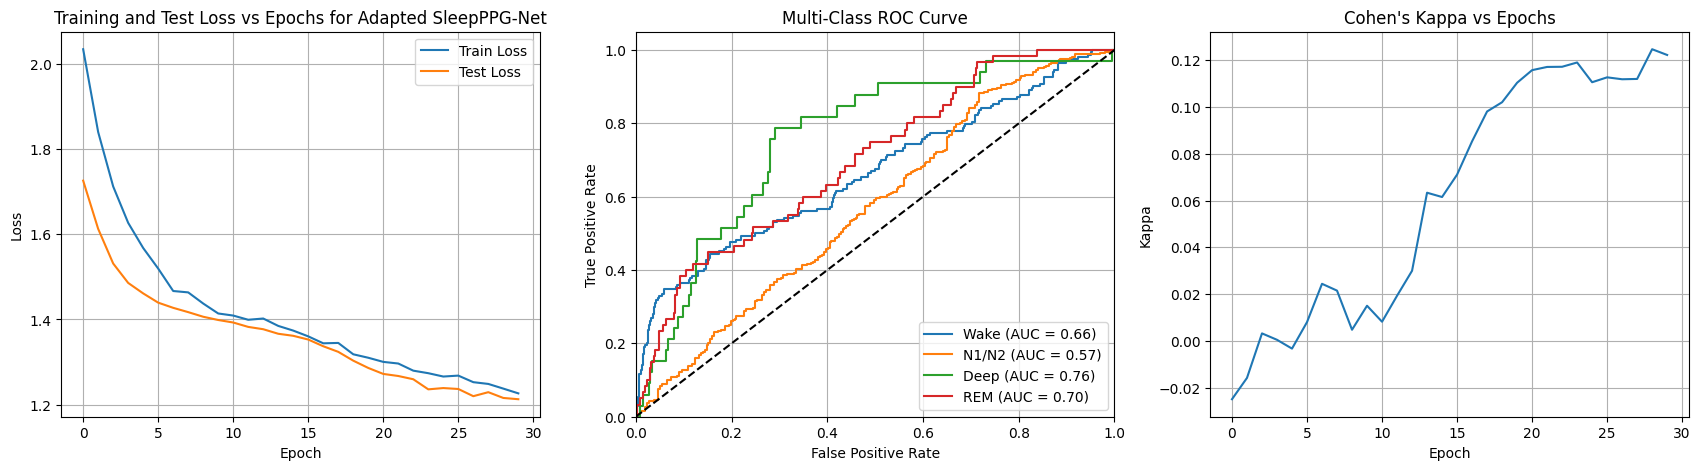

In [158]:
fig, ax = plt.subplots(ncols=3,figsize=(21,5))
# Plot the training and test losses over epochs
#plt.figure(figsize=(7, 5))
ax[0].plot(train_losses, label="Train Loss")
ax[0].plot(valid_losses, label="Test Loss")
#ax[0].set_ylim(1.2,1.6)
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].grid()
ax[0].set_title("Training and Test Loss vs Epochs for Adapted SleepPPG-Net")
ax[0].legend()

valid_labels_ = valid_labels[-1].cpu().detach().numpy()
valid_logits_ = valid_logits[-1].cpu().detach().numpy()

y_true = pd.DataFrame(data = {i: (valid_labels_ == i).astype(int) for i in range(4)}).to_numpy()
y_score = F.softmax(valid_logits[-1].cpu().detach(),dim=1).numpy()

SLEEP_CLASS_MAPPING = {
    0: "Wake",    # Wake
    1: "N1/N2",  # non-REM stage 1 (light)
    2: "Deep",   # REM
    3: "REM"
}
n_classes = len(SLEEP_CLASS_MAPPING)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

for i in range(n_classes):
    ax[1].plot(fpr[i], tpr[i], label=f"{SLEEP_CLASS_MAPPING[i]} (AUC = {roc_auc[i]:.2f})")
ax[1].plot([0,1], [0,1], 'k--')
ax[1].set_xlim([0.0, 1.0])
ax[1].set_ylim([0.0, 1.05])
ax[1].set_xlabel("False Positive Rate")
ax[1].set_ylabel("True Positive Rate")
ax[1].set_title("Multi-Class ROC Curve")
ax[1].legend(loc="lower right")
ax[1].grid(True)

ax[2].plot(kappas)
ax[2].set_xlabel("Epoch")
ax[2].set_ylabel("Kappa")
ax[2].set_title("Cohen's Kappa vs Epochs")
ax[2].grid(True)

#### Plot Test Set Confusion Matrix and Performance Metrics

[[0.37195122 0.1402439  0.2804878  0.20731707]
 [0.12010444 0.17232376 0.36553525 0.34203655]
 [0.12121212 0.06060606 0.75757576 0.06060606]
 [0.05       0.18333333 0.23333333 0.53333333]]


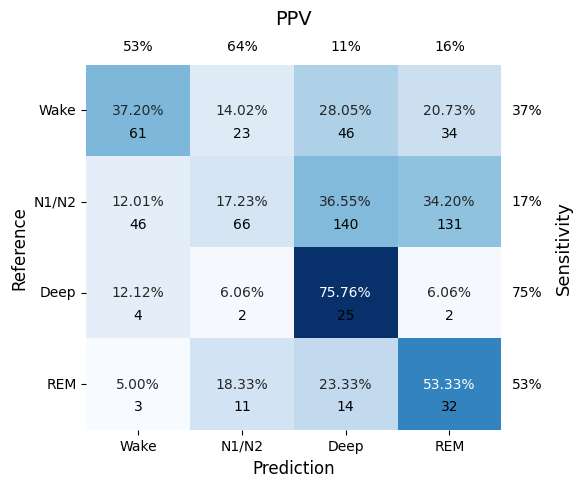

In [169]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

#y_true is an array of the true label class for the sample set with shape (n_samples,) 
#y_pred is an array of the predicted class for the sample set with shape (n_samples,)
#class_mapping is a dictionary that maps the class number to the class string like shown below
class_mapping = {
    0: "Wake",    # Wake
    1: "N1/N2",  # non-REM stage 1 (light)
    2: "Deep",   # non-REM stage 3 (deep)
    3: "REM"   # REM
}

def plot_confusion_matrix_with_metrics(y_true, y_pred, class_mapping):
    class_vals = [i for i in class_mapping.keys()]
    class_names = [class_mapping[i] for i in range(len(class_vals))]
    cm = confusion_matrix(y_true, y_pred, labels=range(len(class_vals)))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float)   # row-wise percentage (sensitivity)
    # Calculate Sensitivity (Recall) and PPV (Precision)
    sensitivity = np.diag(cm) / np.sum(cm, axis=1)
    ppv = np.diag(cm) / np.sum(cm, axis=0)

    fig, ax = plt.subplots(figsize=(6, 5))
    sns.heatmap(cm_perc, annot=True, fmt='.2%', cmap='Blues', cbar=False, ax=ax)

    # Labels inside the boxes
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            count = cm[i, j]
            perc = cm_perc[i, j]
       #     ax.text(j + 0.5, i + 0.3, f"{count:,}", 
        #            ha='center', va='center', color='black', fontsize=10)
            ax.text(j + 0.5, i + 0.75, f"{count:.0f}", 
                    ha='center', va='center', color='black', fontsize=10)

    # Set axis labels
    ax.set_xlabel('Prediction', fontsize=12)
    ax.set_ylabel('Reference', fontsize=12)

    # Set ticks
    ax.set_xticks(np.arange(len(class_vals)) + 0.5)
    ax.set_yticks(np.arange(len(class_vals)) + 0.5)

    ax.set_xticklabels(class_names, rotation=0, ha="center")
    ax.set_yticklabels(class_names, rotation=0)

    # Plot PPV (precision) on top
    for j, p in enumerate(ppv):
        ax.text(j + 0.5, -0.2, f"{int(p*100) if not np.isnan(p) else 0}%", 
                ha='center', va='center', color='black', fontsize=10)

    # Plot Sensitivity (recall) on right
    for i, s in enumerate(sensitivity):
        ax.text(len(class_names) + 0.1, i + 0.5, f"{int(s*100) if not np.isnan(s) else 0}%", 
                ha='left', va='center', color='black', fontsize=10)

    # Center "PPV" label on top
    ax.text(len(class_vals) / 2, -0.5, "PPV", fontsize=14, ha='center', va='center')

    # Center "Sensitivity" label on the right
    ax.text(len(class_vals) + 0.6, len(class_vals) / 2, "Sensitivity", fontsize=13, ha='center', va='center', rotation=90)

    plt.tight_layout()
    plt.show()
y_pred = np.argmax(y_score,axis=1)
plot_confusion_matrix_with_metrics(valid_labels_, y_pred, class_mapping)

#evaluation metrics 
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=8, shuffle=True)
test_loss, test_acc, test_cohens_kappa, test_logit, test_label = evaluate(model, test_dataloader, criterion, device)
test_auroc = roc_auc_score(
    test_label.cpu().numpy(),
    F.softmax(test_logit.cpu(),dim=1).numpy(),
    multi_class="ovo",
    average="macro",
)

print(f"auroc: {test_auroc:.2f}, cohen's kappa: {test_cohens_kappa:.2f}, accuracy: {test_acc: .2f}")